In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Read Data

In [4]:
def read_dataset(inf, objects_count):
    features = []
    labels = []
    
    for i in range(objects_count):
        object_info = [int(i) for i in inf.readline().split()]
        labels += [object_info[-1]]
        object_info[-1] = -1
        features += [object_info]
    
    return np.mat(features), np.mat(labels).transpose()

In [5]:
def get_datasets(dataset_num):
    filepath = "datasets/" + str(dataset_num) + ".txt"

    with open(filepath) as inf:
        features_count = int(inf.readline())
        train_objects_count = int(inf.readline())
        train_features, train_labels = read_dataset(inf, train_objects_count)

        test_objects_count = int(inf.readline())
        test_features, test_labels = read_dataset(inf, test_objects_count)

    return train_features, train_labels, test_features, test_labels

In [6]:
dataset_num = 5

train_features, train_labels, test_features, test_labels = get_datasets(dataset_num)

In [7]:
v, d, u = np.linalg.svd(train_features, full_matrices=False)
v = v.transpose()
u = u.transpose()
# d = np.linalg.inv(np.diag(d + np.array([0.01] * d.shape[0])))

## NRMSD

In [9]:
def nrmsd(weights, features, labels):
    errors = (weights * features.transpose()) - labels.transpose()
    errors = errors * errors.transpose()

    return np.array(math.sqrt(errors / len(test_labels)) / (max(labels) - min(labels))).flat[0]

<h2>SVD</h2>

In [10]:
def svd(train_features, train_labels, d_factor):
    v, d, u = np.linalg.svd(train_features, full_matrices=False)
    v = v.transpose()
    u = u.transpose()
    d = np.linalg.inv(np.diag(d + np.array([d_factor] * d.shape[0])))

    return u * d * v * train_labels

<h2>Gradient Descent</h2>

In [11]:
def gradient_descent(train_features, train_labels, test_features, test_labels, epoch_count, learning_rate):
    weights = np.mat(np.random.randn(train_features.shape[1]))

    errors = []
    for i in tqdm(range(epoch_count)):
        errors += [nrmsd(weights, test_features, test_labels)]
        weights -= calculate_gradient(train_features, train_labels, weights, learning_rate)

    return errors

In [12]:
def calculate_gradient(train_features, train_labels, weights, learning_rate):
    forecast = train_features * weights.transpose()
    deriavate = (forecast - train_labels) * 2
    gradient = train_features.transpose() * deriavate * learning_rate

    return gradient.transpose()

## EVO

In [13]:
def evo(train_features, train_labels, test_features, test_labels, population_size, epoch_count):
    population = []
    for i in range(population_size):
        population += [np.array(np.random.randn(train_features.shape[1]))]

    errors = []
    for i in tqdm(range(epoch_count)):
        population, best_individual = process_epoch(population, population_size, train_features, train_labels)
        errors += [nrmsd(best_individual, test_features, test_labels)]

        if i == 200 and errors[-1] > 0.1:
            break

    return errors

In [14]:
def process_epoch(population, population_size, train_features, train_labels):
    population, best_individual = get_most_adaptable(population)
    population = pair_individuals(population, population_size)

    return population, np.mat(best_individual)

In [15]:
def get_most_adaptable(population):
    errors = []
    for ind in population:
        errors += [nrmsd(ind, train_features, train_labels)]

    avg_error = sum(errors) / len(errors)
    min_error = min(errors)

    survivors = []
    for i in range(len(errors)):
        if errors[i] < avg_error:
            survivors += [population[i]]
        
        if errors[i] == min_error:
            best_individual = i
    
    return survivors, population[best_individual]

In [16]:
def pair_individuals(population, population_size):
    if len(population) == 1:
        population += merge([population[0], population[0]])

    new_population = []
    for i in range(0, len(population) - 1, 2):
        new_population += merge([population[i], population[i + 1]])

    if len(population) % 2 == 1:
        new_population += [mutate(population[-1])]

    while len(new_population) < population_size:
        new_population += [mutate(population[random.randint(0, len(population) - 1)])]

    return new_population

In [17]:
def merge(pair):
    first_child = []
    second_child = []
    for i in range(len(pair[0])):
        first_child += [pair[random.randint(0, 1)][i]]
        second_child += [pair[random.randint(0, 1)][i]]

    family = []
    if survived(75):
        family += [first_child]
    if survived(75):
        family += [second_child]
    if survived(25):
        family += [pair[0]]
    if survived(25):
        family += [pair[1]]

    return family

In [18]:
def mutate(ind):
    return np.array(ind) + np.array(np.random.normal(0, 0.1, len(ind)))

In [19]:
def survived(percent_chance):
    return random.randint(1, 100) < percent_chance

## Results

In [20]:
epoch_count = 1488
d_factor = 0.01

x_axis = list(range(epoch_count))
svd_results = [nrmsd(svd(train_features, train_labels, d_factor).transpose(), test_features, test_labels)] * epoch_count
gradient_results = gradient_descent(train_features, train_labels, test_features, test_labels, epoch_count, 1e-18)
evo_results = evo(train_features, train_labels, test_features, test_labels, 30, epoch_count)

100%|██████████| 1488/1488 [05:23&lt;00:00,  4.61it/s]


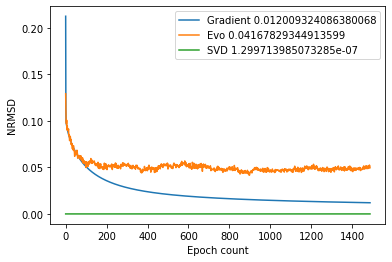

In [21]:
_, chart = plt.subplots()

chart.plot(x_axis, gradient_results, label = "Gradient " + str(min(gradient_results)))
chart.plot(x_axis, evo_results, label = "Evo " + str(min(evo_results)))
chart.plot(x_axis, svd_results, label = "SVD " + str(min(svd_results)))

chart.legend()
chart.set_xlabel("Epoch count")
chart.set_ylabel("NRMSD")

plt.show()